In [1]:
import torch
import numpy as np
from sklearn.datasets import load_digits
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from torch import nn
from torch.autograd import Variable
from torch.optim import SGD

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# nn.RNN?
# train_test_split?
# SGD?
# nn.CrossEntropyLoss?
# nn.LSTM?
# np.where?

In [3]:
all_epoches = 1000

In [4]:
digits = load_digits()

In [5]:
X = digits.data
X = X.astype(np.float32)

In [6]:
X.shape

(1797, 64)

In [7]:
X = X.reshape(-1, 8, 8)

In [8]:
X_0 = X[1, :]

In [9]:
X_0.shape

(8, 8)

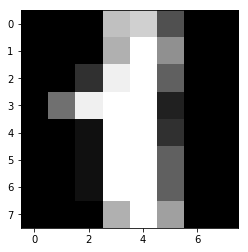

In [10]:
plt.imshow(X_0, cmap='gray')

In [11]:
y = digits.target
y = y.astype(np.int)

In [12]:
y.shape

(1797,)

In [13]:
y_0 = y[1]

In [14]:
y_0

1

In [15]:
class rnn_mnist_net(nn.Module):
    def __init__(self):
        super(rnn_mnist_net, self).__init__()
        self.input_size = 8
        self.hidden_size = 20
        self.output_size = 10
        self.num_layers = 3
        self.bidirectional = True
        self.rnn_out_bi = 1
        # 其中num_layers表示深度，bidirectional表示双向
        self.rnn = nn.RNN(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, bidirectional=self.bidirectional, dropout=0.5)
        if self.bidirectional:
            self.rnn_out_bi = 2
        self.linear = nn.Linear(in_features=self.hidden_size*self.rnn_out_bi, out_features=self.output_size)
        pass
    def forward(self, x):
        """
        x: seq_len*batch_size*input_size
        """
        self.seq_len, self.batch_size, self.input_size = x.size()
#         print('self.seq_len:', self.seq_len)
#         print('self.batch_size:', self.batch_size)
#         print('self.input_size:', self.input_size)
#         x = Variable(torch.randn(5, 3, 10))
        
#         if self.rnn_hidden is None:
#             self.rnn_hidden = Variable(torch.randn((self.num_layers, self.batch_size, self.hidden_size)))
        out, _ = self.rnn(x) # rnn_out seq_len*batch_size*hidden_size
        out = out[-1, :, :]
        out = self.linear(out)
        return out    


In [16]:
def int_to_onehot(int_data, onehot_class):
    """
    int_data:(batch_size,)
    out_onehot:(batch_size, onehot_class)
    """
    batch_size = int_data.shape[0]
    out_onehot = np.zeros((batch_size, onehot_class)).astype(int_data.dtype)
    for batch_i in range(batch_size):
        int_data_batch_i = int_data[batch_i]
        out_onehot_batch_i = out_onehot[batch_i]
        out_onehot_batch_i[int_data_batch_i] = 1
    return out_onehot

In [17]:
def onehot_to_int(out_onehot):
    """
    int_data:(batch_size,)
    out_onehot:(batch_size, onehot_class)
    """
    batch_size = out_onehot.shape[0]
    int_data = np.zeros((batch_size)).astype(out_onehot.dtype)
    for batch_i in range(batch_size):
        out_onehot_batch_i = out_onehot[batch_i]
        int_data[batch_i] = np.where(out_onehot_batch_i==1)[0][0]
    return int_data

In [18]:
# y_one_hot = int_to_onehot(y, 10)

In [19]:
# y_int = onehot_to_int(y_one_hot)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [21]:
X_train.dtype

dtype('float32')

In [22]:
y_train.dtype

dtype('int64')

In [23]:
# seq_len first
X_train = X_train.transpose((1, 0, 2))
X_test = X_test.transpose((1, 0, 2))

In [24]:
X_train_var = Variable(torch.from_numpy(X_train), requires_grad=True)
y_train_var = Variable(torch.from_numpy(y_train))
X_test_var = Variable(torch.from_numpy(X_test))
y_test_var = Variable(torch.from_numpy(y_test))

In [25]:
rnn_net = rnn_mnist_net()

In [26]:
criterion = nn.CrossEntropyLoss()

In [27]:
optimizer = torch.optim.SGD(rnn_net.parameters(), lr=0.1, momentum=0.9)

In [28]:
loss_rnn_list = []
loss_rnn_test_list = []
for epoch in range(all_epoches):
    optimizer.zero_grad()
    y_train_pred_var = rnn_net(X_train_var)
#     print('y_train_pred_var.size():', y_train_pred_var.size())
#     print('y_train_var.size():', y_train_var.size())
    loss = criterion(y_train_pred_var, y_train_var)
#     print('loss.size():', loss.size())
    if epoch%1==0:
        loss_np = loss.data.numpy()
        loss_rnn_list.append(loss_np)
        
        y_test_pred_var = rnn_net(X_test_var)
        loss_test = criterion(y_test_pred_var, y_test_var)
        loss_test_np = loss_test.data.numpy()
        loss_rnn_test_list.append(loss_test_np)
#         print('loss_np:', loss_np)
    loss.backward()
    optimizer.step()
loss_rnn_list = np.array(loss_rnn_list)
loss_rnn_test_list = np.array(loss_rnn_test_list)

In [29]:
class lstm_mnist_net(nn.Module):
    def __init__(self):
        super(lstm_mnist_net, self).__init__()
        self.input_size = 8
        self.hidden_size = 20
        self.output_size = 10
        self.num_layers = 1
        self.bidirectional = False
        self.lstm_out_bi = 1
        # 其中num_layers表示深度，bidirectional表示双向
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, bidirectional=self.bidirectional)
        if self.bidirectional:
            self.lstm_out_bi = 2
        self.linear = nn.Linear(in_features=self.hidden_size*self.lstm_out_bi, out_features=self.output_size)
        pass
    def forward(self, x):
        """
        x: seq_len*batch_size*input_size
        """
        self.seq_len, self.batch_size, self.input_size = x.size()
        out, _ = self.lstm(x) # rnn_out seq_len*batch_size*hidden_size
        out = out[-1, :, :]
        out = self.linear(out)
        return out

In [30]:
lstm_net = lstm_mnist_net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(lstm_net.parameters(), lr=0.1, momentum=0.9)

In [31]:
loss_lstm_list = []
loss_lstm_test_list = []
for epoch in range(all_epoches):
    optimizer.zero_grad()
    y_train_pred_var = lstm_net(X_train_var)
#     print('y_train_pred_var.size():', y_train_pred_var.size())
#     print('y_train_var.size():', y_train_var.size())
    loss = criterion(y_train_pred_var, y_train_var)
#     print('loss.size():', loss.size())
    if epoch%1==0:
        loss_np = loss.data.numpy()
        loss_lstm_list.append(loss_np)
        
        y_test_pred_var = lstm_net(X_test_var)
        loss_test = criterion(y_test_pred_var, y_test_var)
        loss_test_np = loss_test.data.numpy()
        loss_lstm_test_list.append(loss_test_np)
#         print('loss_np:', loss_np)
    loss.backward()
    optimizer.step()
loss_lstm_list = np.array(loss_lstm_list)
loss_lstm_test_list = np.array(loss_lstm_test_list)

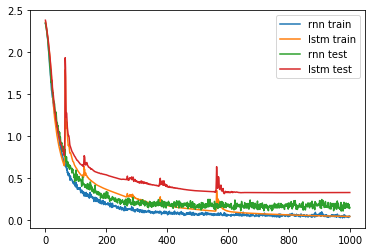

In [32]:
plt.plot(loss_rnn_list, label='rnn train')
plt.plot(loss_lstm_list, label='lstm train')
plt.plot(loss_rnn_test_list, label='rnn test')
plt.plot(loss_lstm_test_list, label='lstm test')
plt.legend()

In [33]:
test_sample_num = y_test.shape[0]

y_test_pred_var = rnn_net(X_test_var)
y_test_pred_var_np = y_test_pred_var.data.numpy()

y_test_pred_var_np_int = y_test_pred_var_np.argmax(axis=1)
acc_rnn = np.sum(y_test_pred_var_np_int == y_test) * 1.0 /test_sample_num
print('acc_rnn:', acc_rnn)

('acc_rnn:', 0.95286195286195285)


In [34]:
test_sample_num = y_test.shape[0]

y_test_pred_var = lstm_net(X_test_var)
y_test_pred_var_np = y_test_pred_var.data.numpy()

y_test_pred_var_np_int = y_test_pred_var_np.argmax(axis=1)
acc_lstm = np.sum(y_test_pred_var_np_int == y_test) * 1.0 /test_sample_num
print('acc_lstm:', acc_lstm)

('acc_lstm:', 0.89393939393939392)
